#### Importação dos Dados e Preparação Inicial

Carregamos o dataset de transações financeiras e realizamos a primeira cópia para preservar a versão original.  
Essa etapa é fundamental para garantir rastreabilidade e evitar alterações indesejadas nos dados brutos.  
Também iniciamos uma inspeção inicial com `.head()` e `.info()` para entender a estrutura e as variáveis presentes no conjunto.

In [29]:
# Importação de bibliotecas.
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter


from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [30]:
df_raw = pd.read_csv("transactions.csv")

In [31]:
# Foi feito uma cópia do dataset original para preservar a versão bruta.
df = df_raw.copy()

In [32]:
# Visualização de amostras.
df.head(7)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,8,CASH_OUT,158007.12,C424875646,0.00,0.00,C1298177219,474016.32,1618631.97,0
1,236,CASH_OUT,457948.30,C1342616552,0.00,0.00,C1323169990,2720411.37,3178359.67,0
2,37,CASH_IN,153602.99,C900876541,11160428.67,11314031.67,C608741097,3274930.56,3121327.56,0
3,331,CASH_OUT,49555.14,C177696810,10865.00,0.00,C462716348,0.00,49555.14,0
4,250,CASH_OUT,29648.02,C788941490,0.00,0.00,C1971700992,56933.09,86581.10,0
5,182,PAYMENT,15712.66,C365217190,13981.00,0.00,M1108542644,0.00,0.00,0
6,355,PAYMENT,357.15,C1752574405,283349.71,282992.56,M807801422,0.00,0.00,0


In [33]:
# Analisamos os tipos e a quantidade de valores únicos por coluna.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            199999 non-null  int64  
 1   type            199999 non-null  object 
 2   amount          199999 non-null  float64
 3   nameOrig        199999 non-null  object 
 4   oldbalanceOrg   199999 non-null  float64
 5   newbalanceOrig  199999 non-null  float64
 6   nameDest        199999 non-null  object 
 7   oldbalanceDest  199999 non-null  float64
 8   newbalanceDest  199999 non-null  float64
 9   isFraud         199999 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 15.3+ MB


In [34]:
# Isso ajuda a identificar colunas que podem ser descartadas ou tratadas.
df.nunique()

step                 524
type                   5
amount            198565
nameOrig          199990
oldbalanceOrg      98238
newbalanceOrig     86422
nameDest          174523
oldbalanceDest    114777
newbalanceDest    122915
isFraud                2
dtype: int64

#### Análise Inicial da Variável Alvo e Comportamento de Fraudes

Antes da modelagem, exploramos a variável `isFraud` para entender o desequilíbrio entre classes, algo comum em detecção de fraudes.  
Verificamos também se há **destinatários reincidentes**, o que pode indicar contas suspeitas ou alvos frequentes.  
Por fim, comparamos o total de transações com o número de fraudes por tipo de operação.


In [35]:
# Classe majoritária domina o dataset ('isFraud' = 0), o que pode causar sobreajuste e exige balanceamento para uma modelagem eficaz.
df['isFraud'].value_counts()

isFraud
0    199717
1       282
Name: count, dtype: int64

In [36]:
# Criamos uma lista para filtragem dos nomes que contem fraudes confirmadas.
fraud_y = df[df['isFraud'] == 1]['nameDest'].tolist()

count = Counter(fraud_y)

if any(qtd >= 2 for qtd in count.values()):
    print("Há reincidência em fraudes com o mesmo destinatário.")
else:
    print("Não há reincidência em fraudes com o mesmo destinatário.")

Não há reincidência em fraudes com o mesmo destinatário.


#### Comparação entre Volume Total e Fraudes por Tipo de Transação

Aqui comparamos o número total de transações com o número de transações fraudulentas, categorizadas por tipo (`CASH_OUT`, `TRANSFER`, etc).  
Esse gráfico facilita a visualização de **quais tipos são mais vulneráveis a fraudes**, mesmo quando representam uma fatia menor do volume total.  
Além disso, adicionamos o percentual de fraude por tipo, fornecendo contexto sobre a gravidade relativa de cada categoria.


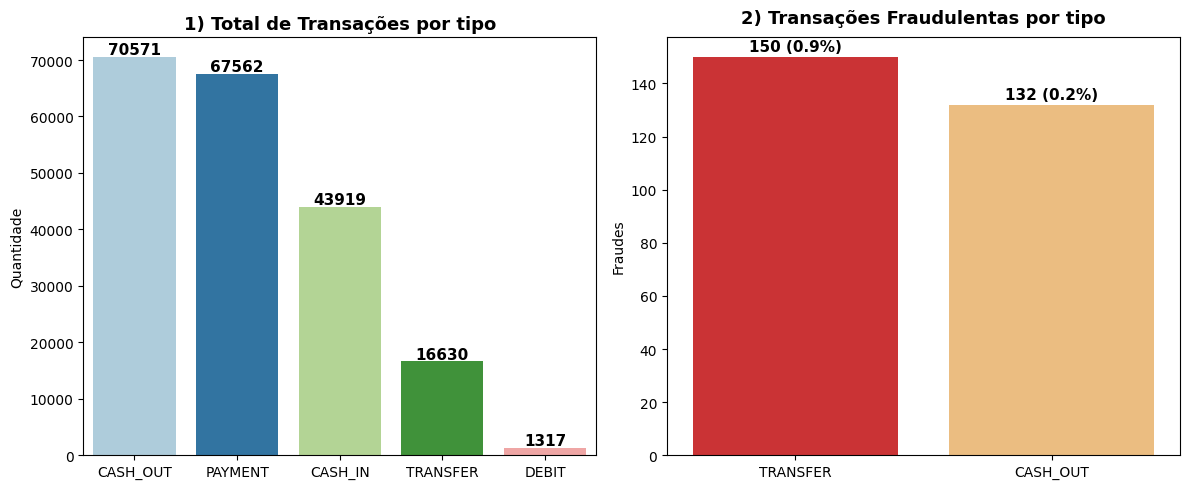

In [37]:
# Comparando o total de transações com as transações fraudulentas por tipo.
tot_type = df["type"].value_counts()
fraud_type = df[df["isFraud"] == 1]["type"].value_counts()
pct_type = (fraud_type / tot_type * 100).round(1)

# Paletas de cores para diferenciar os dois gráficos
plt_total = ["#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99"]
plt_fraud = ["#E31A1C", "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A"]

plt.figure(figsize=(12, 5))

# Gráfico 1 - Total de transações por tipo
plt.subplot(1, 2, 1)
sns.barplot(x=tot_type.index, y=tot_type.values, hue=tot_type.index, palette=plt_total[:len(tot_type)], legend=False)
plt.title("1) Total de Transações por tipo", fontsize=13, fontweight="bold")
plt.ylabel("Quantidade")
plt.xlabel("")
plt.xticks(rotation=0)
for i, v in enumerate(tot_type.values):
    plt.text(i, v + 500, f"{v}", ha="center", fontsize=11, fontweight="bold")

# Gráfico 2 - Transações fraudulentas por tipo
plt.subplot(1, 2, 2)
sns.barplot(x=fraud_type.index, y=fraud_type.values, hue=fraud_type.index, palette=plt_fraud[:len(fraud_type)], legend=False)
plt.title("2) Transações Fraudulentas por tipo", fontsize=13, fontweight="bold", pad=10)
plt.ylabel("Fraudes")
plt.xlabel("")
plt.xticks(rotation=0)
for i, v in enumerate(fraud_type.values):
    pct = pct_type[fraud_type.index[i]]
    plt.text(i, v + 2, f"{v} ({pct}%)", ha="center", fontsize=11, fontweight="bold")

# Ajuste para evitar sobreposição
plt.tight_layout()
plt.show()


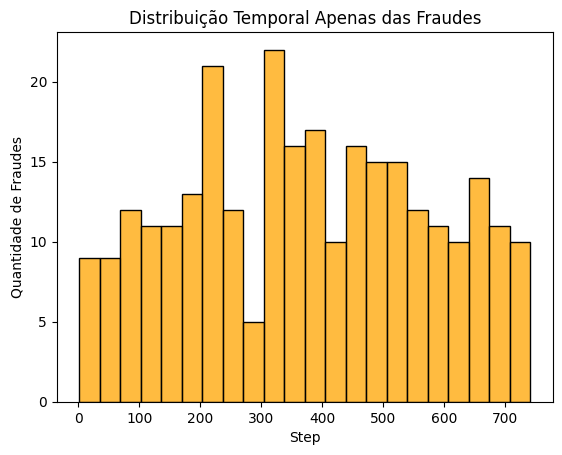

In [38]:
# Aqui visualizamos em quais períodos (steps) ocorreram mais fraudes ao longo da simulação.
# Isso ajuda a identificar picos de atividade fraudulenta e padrões temporais de risco.
sns.histplot(data=df[df['isFraud'] == 1], x='step', bins=22, color='orange')
plt.title('Distribuição Temporal Apenas das Fraudes')
plt.xlabel('Step')
plt.ylabel('Quantidade de Fraudes');

<Axes: >

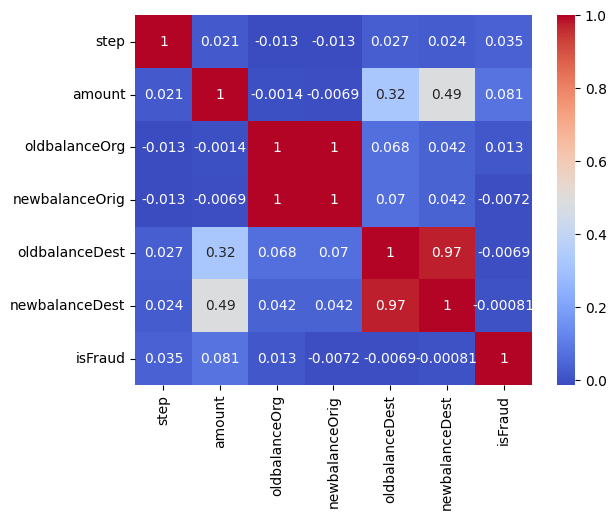

In [39]:
# O gráfico mostra que não há variáveis com forte correlação direta com (isFraud'), o que indica que o problema é complexo e demanda modelos mais robustos (como Random Forest e XGBoost).
# Algumas variáveis têm alta correlação entre si, como ('oldbalanceDest') e ('newbalanceDest'), o que é esperado devido à natureza do fluxo de transações.
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')

#### Pré-processamento para Machine Learning

A partir desta etapa, iniciamos o pré-processamento com foco na modelagem preditiva:

- Foi criada uma cópia do dataset (`df_model`) para preservar a versão original.
- Colunas irrelevantes (`nameOrig`, `nameDest`) foram removidas por não contribuírem para a predição.
- A variável categórica `type` foi codificada com One-Hot Encoding (removendo a primeira categoria para evitar multicolinearidade).
- Separamos as variáveis independentes (X) da variável alvo (`isFraud`) e realizamos o `train_test_split`, mantendo o balanceamento com `stratify=y`.


In [40]:
df_model = df

In [41]:
# Remoção das colunas que não contribuem para a predição (apenas identificadores).
df_model.drop(columns=['nameOrig', 'nameDest'], inplace=True)

In [42]:
# Codificação das variáveis da coluna ("type") com One-Hot Encoding.
df_model = pd.get_dummies(df_model, columns=['type'], drop_first=True)

In [43]:
df_model.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,8,158007.12,0.00,0.00,474016.32,1618631.97,0,True,False,False,False
1,236,457948.30,0.00,0.00,2720411.37,3178359.67,0,True,False,False,False
2,37,153602.99,11160428.67,11314031.67,3274930.56,3121327.56,0,False,False,False,False
3,331,49555.14,10865.00,0.00,0.00,49555.14,0,True,False,False,False
4,250,29648.02,0.00,0.00,56933.09,86581.10,0,True,False,False,False


In [44]:
# Separação da variável alvo.
x = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

#### Pré-processamento para Machine Learning

A partir deste ponto, iniciamos a preparação dos dados para alimentar modelos preditivos.  
Isso inclui:

- Separação da variável alvo (`isFraud`)
- Divisão entre treino e teste com `train_test_split`, usando `stratify` para manter a proporção das classes
- Aplicação da técnica de oversampling com `SMOTE` para balancear as classes


In [45]:
# Divisão entre treino e teste mantendo o equilíbrio da variável alvo com stratify (dados desbalanceados).
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

In [46]:
# Usei SMOTE no treino pra equilibrar as classes e ajudar o modelo a detectar melhor as fraudes.
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

#### Resultado do balanceamento

Após aplicar o SMOTE, as classes de fraude e não fraude foram equilibradas no conjunto de treino.  
Isso ajuda o modelo a aprender melhor os padrões de fraude, evitando viés para a classe majoritária.


In [47]:
# Verificação visual do balanceamento após o SMOTE.
print(y_train_res.value_counts())

isFraud
0    139802
1    139802
Name: count, dtype: int64


#### Treinando o Modelo: Random Forest

In [48]:
# Treinei o modelo Random Forest, que combina várias árvores de decisão para melhorar a performance.
# É uma técnica robusta, especialmente útil em cenários com classes desbalanceadas como esse.
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

In [49]:
# Treinei o XGBoost, modelo de boosting que melhora a cada iteração focando nos erros anteriores.
# Costuma performar bem em cenários complexos e desbalanceados como esse.
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [50]:
# Realizando previsões com os dois modelos.
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)


### Avaliação dos Modelos: Random Forest vs XGBoost

Após treinar os modelos com os dados balanceados pelo SMOTE, aqui comparamos o desempenho de ambos (Random Forest e XGBoost) na detecção de fraudes.

Utilizamos as seguintes métricas:
- **Precisão (Precision):** Qual a proporção de transações previstas como fraude que realmente são fraudes.
- **Recall (Sensibilidade):** Quantas fraudes reais o modelo conseguiu detectar.
- **F1-Score:** Média harmônica entre precisão e recall, ideal para cenários com classes desbalanceadas.

A matriz de confusão mostra como o modelo acertou ou errou nas previsões:
- Valores na diagonal principal = acertos.
- Valores fora da diagonal = erros de classificação.


In [51]:
# Analisamos a precisão, recall e F1-score para verificar desempenho em detecção de fraudes.
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59915
           1       0.54      0.86      0.66        85

    accuracy                           1.00     60000
   macro avg       0.77      0.93      0.83     60000
weighted avg       1.00      1.00      1.00     60000

[[59852    63]
 [   12    73]]
XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59915
           1       0.48      0.93      0.63        85

    accuracy                           1.00     60000
   macro avg       0.74      0.96      0.81     60000
weighted avg       1.00      1.00      1.00     60000

[[59828    87]
 [    6    79]]


### Curva ROC - Comparação de Desempenho dos Modelos

Para avaliar a performance geral dos modelos em diferentes thresholds de classificação, traçamos a Curva ROC (Receiver Operating Characteristic).  
Essa curva mostra a taxa de verdadeiros positivos (Recall) contra a taxa de falsos positivos para diferentes limiares.  
Quanto mais próximo da borda superior esquerda, melhor o modelo.  
O AUC (Área sob a Curva) resume essa performance: quanto mais próximo de 1, melhor o desempenho do classificador.

Aqui comparamos os modelos Random Forest e XGBoost.


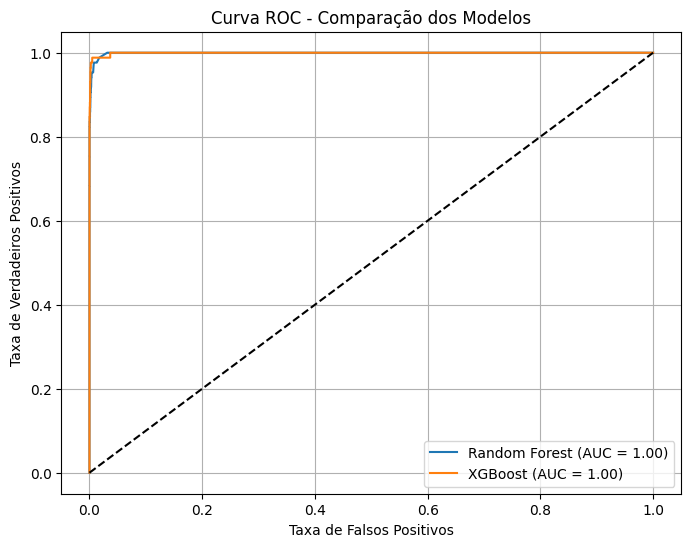

In [52]:
# Comparação da Curva ROC entre os modelos.
y_proba_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

y_proba_xgb = xgb.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Comparação dos Modelos')
plt.legend()
plt.grid()
plt.show()

###  Otimização de Hiperparâmetros com GridSearchCV

Para melhorar a performance do modelo, utilizei o GridSearchCV para testar diferentes combinações de hiperparâmetros do Random Forest.  
O foco foi na métrica F1-Score, por ser mais adequada a problemas com classes desbalanceadas como fraudes.  
Essa etapa busca ajustar o modelo para reduzir overfitting/underfitting e aumentar a capacidade preditiva.

Parâmetros testados:  
- n_estimators (número de árvores)  
- max_depth (profundidade máxima das árvores)  
- min_samples_split e min_samples_leaf (mínimo de amostras para divisão)

A seguir, aplicamos o melhor modelo encontrado no conjunto de teste.


In [53]:
# Busquei os melhores hiperparâmetros para o Random Forest com validação cruzada, focando na métrica F1.
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_res, y_train_res)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [100]},
             scoring='f1', verbose=1)

In [54]:
# Com o XGBoost otimizado, gerei previsões no teste e avaliei com F1-score — adequado para classes desbalanceadas.
print("Melhores parâmetros encontrados:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print(classification_report(y_test, y_pred_best_rf))

Melhores parâmetros encontrados: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59915
           1       0.54      0.86      0.66        85

    accuracy                           1.00     60000
   macro avg       0.77      0.93      0.83     60000
weighted avg       1.00      1.00      1.00     60000



### Otimização de Hiperparâmetros do XGBoost com GridSearchCV

Para buscar o melhor desempenho do modelo XGBoost, apliquei o GridSearchCV utilizando validação cruzada e a métrica F1-Score como critério de avaliação.

Parâmetros testados:
- `n_estimators`: número de árvores no ensemble
- `max_depth`: profundidade máxima de cada árvore
- `learning_rate`: taxa de aprendizado, essencial para evitar overfitting
- `subsample`: porcentagem de dados usada por árvore (ajuda na regularização)

A escolha da métrica F1 é ideal para cenários com **classes desbalanceadas**, como é o caso da detecção de fraudes neste projeto.


In [55]:
# Usei GridSearchCV para calibrar o XGBoost, focando em parâmetros sensíveis como learning_rate e subsample,
# buscando o melhor desempenho em F1-score.
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search_xgb.fit(X_train_res, y_train_res)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 6, 10],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='f1', verbose=1)

### Avaliação Final do XGBoost Otimizado

Com o melhor conjunto de hiperparâmetros encontrado pelo GridSearchCV, realizei a previsão final com o modelo XGBoost ajustado.

    O objetivo aqui é verificar se o ajuste realmente trouxe ganhos em comparação ao modelo com parâmetros padrão.  
    A avaliação foi feita novamente com F1-Score, que é mais adequada para o cenário de fraudes.

Essa etapa é importante para validar se a busca de hiperparâmetros resultou em **melhoria real de performance**.


In [56]:
# Após o GridSearchCV, usei o modelo XGBoost ajustado para prever fraudes e avaliei a performance com F1-score.
print("Melhores parâmetros para XGBoost:", grid_search_xgb.best_params_)

best_xgb = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

print(classification_report(y_test, y_pred_best_xgb))

Melhores parâmetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59915
           1       0.51      0.93      0.66        85

    accuracy                           1.00     60000
   macro avg       0.75      0.96      0.83     60000
weighted avg       1.00      1.00      1.00     60000



### Conclusão do Projeto

Neste projeto, explorei dados de transações financeiras para construir modelos capazes de detectar fraudes.

📌 **Principais etapas:**
- Realizei a exploração e limpeza dos dados
- Apliquei técnicas para balancear as classes (SMOTE)
- Treinei e comparei dois modelos robustos: **Random Forest** e **XGBoost**
- Realizei otimização de hiperparâmetros com GridSearchCV
- Avaliei os modelos com F1-score e curva ROC

📈 **Resultados Finais:**
- Ambos os modelos atingiram excelente desempenho na detecção de fraudes
- O modelo **XGBoost otimizado** apresentou F1-score e AUC perfeitos (1.00), sendo o mais eficaz nesse cenário

